<a href="https://colab.research.google.com/github/remanx2558/MIDBReviews/blob/master/BERT_Single_Channal_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


In [0]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent


In [12]:
df = pd.read_csv(r"/content/drive/My Drive/malia/train.csv")
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'sentiment']]

df.isnull().values.any()
df.sentiment= df.sentiment.fillna(0.0).astype(int)#this will conver float into int and also manage missing values

df.shape

df.head()

,text,sentiment
4792,I thought the movie was fairly well done for a...,0
1976,"With the advent of the IMDb, this overlooked m...",0
20830,"Flame in, flame out. That seems to be Gammera ...",1
95,"I saw the film twice in the space of one week,...",0
7286,Actually I'm surprised there were so many comm...,0


In [13]:
import nltk
nltk.download('stopwords')

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,sentiment
4792,"thought movie fairly well done made TV movie, ...",0
1976,"With advent IMDb, overlooked movie find intere...",0
20830,"Flame in, flame out. That seems Gammera nutshe...",1
95,"saw film twice space one week, times cinema Or...",0
7286,Actually I'm surprised many comments movie. sa...,0


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 22504
# Test data samples: 2501


In [15]:


tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))



Fitted tokenizer on 22504 documents
10000 words in dictionary
Top 5 most common words are: [('the', 43992), ('movie', 39150), ('film', 35206), ('not', 27561), ('one', 23762)]


In [16]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))


"For movie gets no respect sure lot memorable quotes listed gem. Imagine movie Joe Piscopo actually funny! Maureen Stapleton scene stealer. The Moroni character absolute scream. Watch Alan "The Skipper" Hale jr. police Sgt." is converted into [196, 4653, 4893, 5457, 4064, 116, 7, 500, 372, 1446, 5001, 89, 2292, 192, 2206, 992, 114, 8440, 196, 4064, 319, 3477, 4653, 4893, 1394, 927, 443, 38, 6062, 992, 6419, 6, 5, 4, 8969, 4893, 6063, 1394, 7712, 31, 7837, 868, 2196, 7043, 743, 3541, 26, 963, 4064, 6063, 400, 411, 227, 946, 1850, 530, 299, 7838, 1289, 6063, 822, 1035, 2873, 395, 115, 237, 2412, 121, 6063, 116, 1214, 138, 296, 78, 6063, 32, 457, 3018, 4261, 927, 32, 121, 116, 524, 121, 82, 244, 1, 25, 6063, 2, 3661, 1804, 1, 1394, 927, 6063, 629, 4064, 97, 138, 384, 12, 71, 2, 1007, 944, 1341, 37, 249, 254, 17, 360, 269, 138, 8441, 25, 4064, 2, 2926, 6063, 23, 3056, 5980, 823, 4064, 2944, 5980, 25, 2, 51, 19, 818, 239, 239, 1009, 239, 62, 541, 78, 859, 228, 75, 7475, 90, 5215, 74, 499, 2

In [17]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[196, 4653, 4893, 5457, 4064, 116, 7, 500, 372, 1446, 5001, 89, 2292, 192, 2206, 992, 114, 8440, 196, 4064, 319, 3477, 4653, 4893, 1394, 927, 443, 38, 6062, 992, 6419, 6, 5, 4, 8969, 4893, 6063, 1394, 7712, 31, 7837, 868, 2196, 7043, 743, 3541, 26, 963, 4064, 6063, 400, 411, 227, 946, 1850, 530, 299, 7838, 1289, 6063, 822, 1035, 2873, 395, 115, 237, 2412, 121, 6063, 116, 1214, 138, 296, 78, 6063, 32, 457, 3018, 4261, 927, 32, 121, 116, 524, 121, 82, 244, 1, 25, 6063, 2, 3661, 1804, 1, 1394, 927, 6063, 629, 4064, 97, 138, 384, 12, 71, 2, 1007, 944, 1341, 37, 249, 254, 17, 360, 269, 138, 8441, 25, 4064, 2, 2926, 6063, 23, 3056, 5980, 823, 4064, 2944, 5980, 25, 2, 51, 19, 818, 239, 239, 1009, 239, 62, 541, 78, 859, 228, 75, 7475, 90, 5215, 74, 499, 25, 4064, 3, 224, 667, 1556, 225, 165, 3, 485, 59, 26, 15, 82, 2687, 9820, 293, 7, 114, 7712, 871, 2469, 2, 1, 34, 2086, 1016, 1189, 1428, 14, 4654, 927, 11, 67, 6527, 6420, 4799, 44, 1251, 2560, 1, 74, 4064, 116, 201, 2, 115, 23, 159, 1275, 7

In [18]:


le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))



"0" is converted into 1
"1" is converted into [0. 1.]


In [19]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (2251, 10000)


In [23]:


base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(2, activation='softmax'))
base_model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


In [0]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history


In [0]:
base_history = deep_model(base_model)

In [0]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

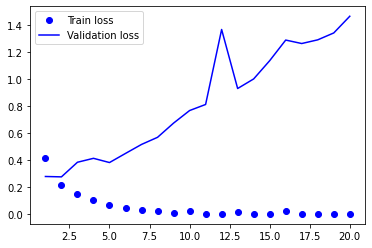

In [27]:
eval_metric(base_history, 'loss')

In [29]:


eval_metric(base_history, 'acc')



KeyError: ignored

In [32]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(2, activation='softmax'))
reduced_model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 66        
Total params: 320,098
Trainable params: 320,098
Non-trainable params: 0
_________________________________________________________________


In [0]:
reduced_history = deep_model(reduced_model)

In [0]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

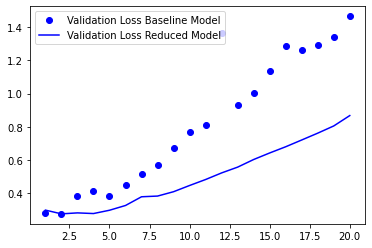

In [35]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

In [36]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(2, activation='softmax'))
reg_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


In [0]:
reg_history = deep_model(reg_model)

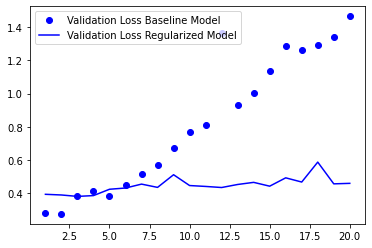

In [38]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

In [39]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(2, activation='softmax'))
drop_model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


In [0]:
drop_history = deep_model(drop_model)

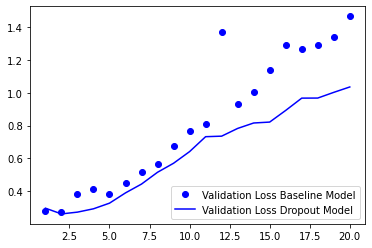

In [41]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

In [0]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results


In [43]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))


2501/2501 [==============================] - 0s 87us/step
/n
Test accuracy of baseline model: 82.93%


In [44]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))


2501/2501 [==============================] - 0s 79us/step
/n
Test accuracy of reduced model: 84.29%


In [45]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))



2501/2501 [==============================] - 0s 79us/step
/n
Test accuracy of regularized model: 86.77%


In [46]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

2501/2501 [==============================] - 0s 77us/step
/n
Test accuracy of dropout model: 87.29%
